## The Susceptible-Infected-Recovered (SIR) model

The SIR model is explained in many places (e.g. [here](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model)). Economists sometimes embed this in a larger economics model, for example this [NBER paper](https://www.nber.org/papers/w26902) working paper and references cited within. 

Python code below by Jonathan Conning, guided by this ['Coronavirus Curve - Numberphile](https://www.youtube.com/watch?v=k6nLfCbAzgo) video.  If you're not doing so already you can run this as an interactive [web app](https://ricardian.herokuapp.com/).  The notebook with code is [here](https://github.com/jhconning/Econ-Teach/blob/master/notebooks/epidemic/SIRmodel.ipynb)

## Basic deterministic Model
The proportion of the population are infected $I_t$, susceptible $S$, and recovered $R$ evolve over time according to these equation swhich depend on the transmission rate $\beta$ and the recovery rate $\gamma$:

$$
\begin{align}
\frac{dI}{dt} &= \beta \cdot S \cdot I - \gamma \cdot I  \\
\frac{dS}{dt} &=-\beta \cdot S \cdot I  \\
\frac{dR}{dt} &= \gamma \cdot I
\end{align}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact, fixed

In [2]:
N = 1          # Size of the population (so everything in proportions)
I0 = 0.01      # Initial proportion of the population infected
S0 = N - I0    # Initial proportion of the population susceptible
R0 = 0.0       # Initial proportion of the population recovered (NOT the basic reproductive number)
maxT = 25      # max number of periods in simulation

beta = 0.5      # transmission rate
gamma = 0.1     # recovery rate

In [3]:
def SIR(y, t, beta, gamma):
    '''the SIR model'''
    S, I, R = y
    dSdt = -beta*S*I
    dIdt = beta*S*I - gamma*I
    dRdt = gamma*I
    return([dSdt, dIdt, dRdt])

In [4]:
def plotSIR(beta = beta, gamma = gamma, maxT = maxT):
    '''Solve differential equations in SIR and plot'''
    t = np.linspace(0, maxT, 1000)
    soln = odeint(SIR,[S0,I0,R0], t, args=(beta, gamma))
    soln = np.array(soln)
    plt.figure(figsize=[8,6])

    plt.plot(t, soln[:,0], linewidth=3, label = 'S(t)')
    plt.plot(t, soln[:,1], linewidth=3, label = 'I(t)')
    plt.plot(t, soln[:,2], linewidth=3, label = 'R(t)')
    plt.grid()
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("proportions")
    plt.title("SIR model")


Change the parameters with the sliders below (you'll only have interactivity with a running jupyter notebook server).

In [5]:
interact(plotSIR, beta=(0,1,0.05), gamma=(0,1,0.05), maxT=(5,100,5));

interactive(children=(FloatSlider(value=0.5, description='beta', max=1.0, step=0.05), FloatSlider(value=0.1, d…

Below is a plot with the default parameters ($\beta=0.5$, $\gamma=0.1$) to have a graphic in case widget above does not display.

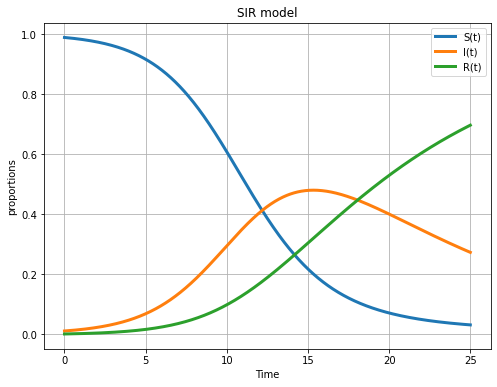

In [6]:
plotSIR(beta, gamma, maxT)

(0.0, 0.5)

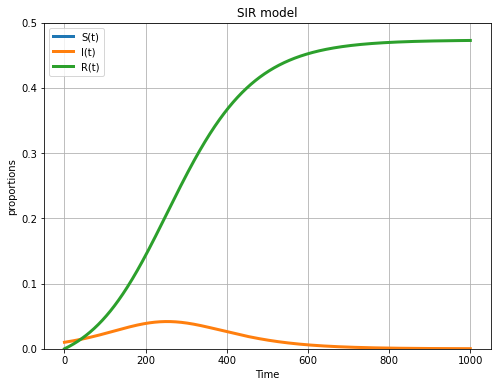

In [7]:
plotSIR(0.04, 0.03, 1000)
plt.ylim(0,0.5)

### Basic Reproductive Number (ratio) $R_0$

$$
R_0 = \frac{\beta}{\gamma}
$$

$R_0$ in Oxford model 2.25 to 2.75 for UK.    

### Fraction of popn that needs to be vaccinated for herd immunity

$$
\left ( 1 - \frac{1}{R_0} \right )
$$

## Extensions

- deaths added to Removed  (IFR, CFR)
- asymptomatics/oblivious (different $\beta$)
- behavioral responses
- contagion over network structures


## Epidemics travel over Networks 

![](media/partier.png)

**Spring Break: Unique cell phones on one Florida Beach March 16**
![](media/beach.jpg)

**Those same cell phones over the course of the following week**
![](media/network_map.jpg)

## SIR over network

In [8]:
import networkx as nx
import ndlib.models.epidemics as ep

from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
output_notebook()

Loading BokehJS ...

## Fun with networks
The Erdos-Renyi method for generating a graph with $n$ nodes and a success probability of $p$ edges per node.

So for example if we have 4 nodes and a success probability of 1 we'll have all possible edges (six in this case).  More generally the number of possible edges is $\frac{n(n-1)}{2}\cdot p$.

In [9]:
def drawg(n=50,m=0.2):
    g = nx.erdos_renyi_graph(n, m)
    nx.draw(g)
    plt.show()

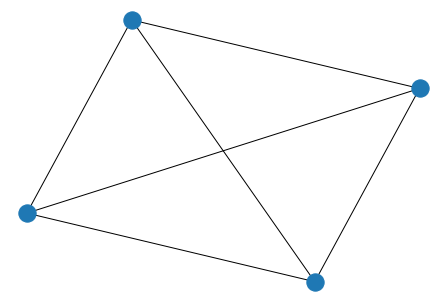

In [10]:
drawg(4,1)

Here is G(10,0.2). Note this network can look quite different each time because it's created at random. 

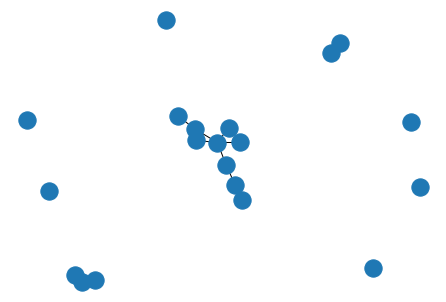

In [11]:
drawg(20,0.05)

In [12]:
interact(drawg, n=(10,50,5), m=(0.025,1,0.025));

interactive(children=(IntSlider(value=50, description='n', max=50, min=10, step=5), FloatSlider(value=0.2, des…

## Stochastic SIR model

Cosma Shalizi's Epidemic Models lecture notes

The number of infections and removals modeled as binomials (corresponding to network theory).
![](media/SIR_n.jpg)

Simulate 10 encounters with a $p=0.25$ chance of infection each time. How many infections? It will a random outcome with binomial distribution.  Here is one simulation of 10 encounters:

In [13]:
np.random.binomial(n=1, p=0.25, size = 10).sum()

0

For everyone in $S_{t-1}$ there is a chance $p=\beta \cdot \frac{I}{n}$ they will contact an infected person and get infected. For example if one tenth the population is infected ($\frac{I}{n}=\frac{1}{10}$) and the transmission rate $\beta = 0.2$ then each susceptible person will become infected with probability 0.02, so 2 percent of the susceptible will get infected next period.

In [14]:
def simsir(n, beta, gamma, T):
    states = np.zeros((T,3))
    S, I, R = n-1, 1, 0
    states[0, :] = [S,I,R]
    for t in range(1,T):
        contagions = np.random.binomial(n=1, p=beta*I/n, size = S).sum()
        removals = np.random.binomial(n=1, p=gamma, size = I).sum()
        S = S - contagions
        I = I  + contagions - removals
        R = R + removals
        states[t,:] = [S, I, R]
    return states


def plotsims(runs=1, n=100, beta=0.25, gamma=0.1, T=100):
    plt.figure(figsize=(10,6))
    if runs > 1:
        alp =0.4
    else:
        alp = 1
    for r in range(runs):
        states = simsir(n, beta, gamma, T)
        plt.plot(states[:,0], color ='blue', alpha = alp)
        plt.plot(states[:,1], color = 'red', alpha = alp)
        plt.plot(states[:,2], color = 'green', alpha = alp)
    plt.grid()


Notice that in a fraction of the runs below the infection never takes off. Random luck determines the path of the infection.

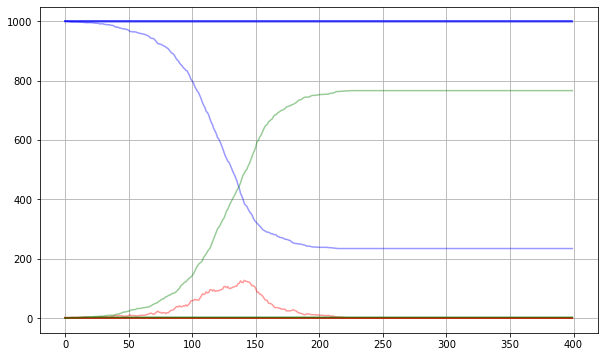

In [15]:
plotsims(runs = 5, n=1000, beta=0.175, gamma=0.1, T=400 )

In [17]:
interact(plotsims, runs = (1,10,1), n=fixed(1000), beta=(0.01,0.2,0.01), gamma=(0.01,0.2,0.01), T=fixed(100) )

interactive(children=(IntSlider(value=1, description='runs', max=10, min=1), FloatSlider(value=0.2, descriptio…

<function __main__.plotsims(runs=1, n=100, beta=0.25, gamma=0.1, T=100)>

## Tradeoffs?

- [CORE-Econ](https://www.core-econ.org/wp-content/uploads/2020/04/The-CORE-Team-Learning-Tool-using-networks-to-understand-COVID-19.pdf) learning tool.
![](media/tradeoff.jpg)


![](media/twonetworks.jpg)

![](media/socdistance.jpg)

Greenstone and Nigam (March 2020)

![](media/social_d.jpg)

![](media/vsl.jpg)

## Notes on possible further

- Estimating stochastic SIR by ML [link](https://kingaa.github.io/short-course/parest/parest.html)

- SIR plus city geography...using origin-destination flows [post](https://lexparsimon.github.io/coronavirus/) and in some more detail [here](https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2)
